In [3]:
!rm -rf code_for_hw8*
!rm -rf mnist
!wget --quiet https://introml_oll.odl.mit.edu/cat-soop/_static/6.036/homework/hw08/code_for_hw8.zip
!unzip code_for_hw8.zip
!mv code_for_hw8/* .

Archive:  code_for_hw8.zip
   creating: code_for_hw8/
  inflating: code_for_hw8/.DS_Store  
replace __MACOSX/code_for_hw8/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: cannot stat 'code_for_hw8/*': No such file or directory


In [4]:
import pdb
import numpy as np
import itertools

import math as m 

import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.datasets import mnist
from keras import backend as K
from keras.initializers import VarianceScaling
from matplotlib import pyplot as plt

In [5]:
######################################################################
# Plotting Functions
######################################################################

def plot_heat(X, y, model, res = 200):
    eps = .1
    xmin = np.min(X[:,0]) - eps; xmax = np.max(X[:,0]) + eps
    ymin = np.min(X[:,1]) - eps; ymax = np.max(X[:,1]) + eps
    ax = tidyPlot(xmin, xmax, ymin, ymax, xlabel = 'x', ylabel = 'y')
    xl = np.linspace(xmin, xmax, res)
    yl = np.linspace(ymin, ymax, res)
    xx, yy = np.meshgrid(xl, yl, sparse=False)
    zz = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    im = ax.imshow(np.flipud(zz.reshape((res,res))), interpolation = 'none',
                   extent = [xmin, xmax, ymin, ymax],
                   cmap = 'viridis')
    plt.colorbar(im)
    for yi in set([int(_y) for _y in set(y)]):
        color = ['r', 'g', 'b'][yi]
        marker = ['X', 'o', 'v'][yi]
        cl = np.where(y==yi)
        ax.scatter(X[cl,0], X[cl,1], c = color, marker = marker, s=80,
                   edgecolors = 'none')
    return ax

def tidyPlot(xmin, xmax, ymin, ymax, center = False, title = None,
                 xlabel = None, ylabel = None):
    plt.figure(facecolor="white")
    ax = plt.subplot()
    if center:
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('zero')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_smart_bounds(True)
        ax.spines['bottom'].set_smart_bounds(True)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    else:
        ax.spines["top"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        ax.get_xaxis().tick_bottom()  
        ax.get_yaxis().tick_left()
    eps = .05
    plt.xlim(xmin-eps, xmax+eps)
    plt.ylim(ymin-eps, ymax+eps)
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    return ax

def plot_separator(ax, th, th_0):
    xmin, xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    pts = []
    eps = 1.0e-6
    # xmin boundary crossing is when xmin th[0] + y th[1] + th_0 = 0
    # that is, y = (-th_0 - xmin th[0]) / th[1]
    if abs(th[1,0]) > eps:
        pts += [np.array([x, (-th_0 - x * th[0,0]) / th[1,0]]) \
                                                        for x in (xmin, xmax)]
    if abs(th[0,0]) > 1.0e-6:
        pts += [np.array([(-th_0 - y * th[1,0]) / th[0,0], y]) \
                                                         for y in (ymin, ymax)]
    in_pts = []
    for p in pts:
        if (xmin-eps) <= p[0] <= (xmax+eps) and \
           (ymin-eps) <= p[1] <= (ymax+eps):
            duplicate = False
            for p1 in in_pts:
                if np.max(np.abs(p - p1)) < 1.0e-6:
                    duplicate = True
            if not duplicate:
                in_pts.append(p)
    if in_pts and len(in_pts) >= 2:
        # Plot separator
        vpts = np.vstack(in_pts)
        ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
        # Plot normal
        vmid = 0.5*(in_pts[0] + in_pts[1])
        scale = np.sum(th*th)**0.5
        diff = in_pts[0] - in_pts[1]
        dist = max(xmax-xmin, ymax-ymin)
        vnrm = vmid + (dist/10)*(th.T[0]/scale)
        vpts = np.vstack([vmid, vnrm])
        ax.plot(vpts[:,0], vpts[:,1], 'k-', lw=2)
        # Try to keep limits from moving around
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
    else:
        print('Separator not in plot range')

def plot_decision(data, cl, diff=False):
    layers = archs(cl)[0]
    X, y, model = run_keras_2d(data, layers, 10, trials=1, verbose=False, display=False)
    ax = plot_heat(X,y,model)
    W = layers[0].get_weights()[0]
    W0 = layers[0].get_weights()[1].reshape((cl,1))
    if diff:
        for i,j in list(itertools.combinations(range(cl),2)):
            plot_separator(ax, W[:,i:i+1] - W[:,j:j+1], W0[i:i+1,:] - W0[j:j+1,:])
    else:
        for i in range(cl):
            plot_separator(ax, W[:,i:i+1], W0[i:i+1,:])
    plt.show()

In [6]:
######################################################################
# Problem 3 - 2D data
######################################################################

def archs(classes):
    return [[Dense(input_dim=2, units=classes, activation="softmax")],
            [Dense(input_dim=2, units=10, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=100, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=10, activation='relu'),
             Dense(units=10, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=100, activation='relu'),
             Dense(units=100, activation='relu'),
             Dense(units=classes, activation="softmax")],
            [Dense(input_dim=2, units=200, activation='relu'),
             Dense(units=200, activation='relu'),
             Dense(units=classes, activation="softmax")]]

# Read the simple 2D dataset files
def get_data_set(name):
    try:
        data = np.loadtxt(name, skiprows=0, delimiter = ' ')
    except:
        return None, None, None
    np.random.shuffle(data)             # shuffle the data
    # The data uses ROW vectors for a data point, that's what Keras assumes.
    _, d = data.shape
    X = data[:,0:d-1]
    Y = data[:,d-1:d]
    y = Y.T[0]
    classes = set(y)
    if classes == set([-1.0, 1.0]):
        print('Convert from -1,1 to 0,1')
        y = 0.5*(y+1)
    print('Loading X', X.shape, 'y', y.shape, 'classes', set(y))
    return X, y, len(classes)

In [7]:
######################################################################
# General helpers for Problems 3-5
######################################################################

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.keys = ['loss', 'acc', 'val_loss', 'val_acc']
        self.values = {}
        for k in self.keys:
            self.values['batch_'+k] = []
            self.values['epoch_'+k] = []

    def on_batch_end(self, batch, logs={}):
        for k in self.keys:
            bk = 'batch_'+k
            if k in logs:
                self.values[bk].append(logs[k])

    def on_epoch_end(self, epoch, logs={}):
        for k in self.keys:
            ek = 'epoch_'+k
            if k in logs:
                self.values[ek].append(logs[k])

    def plot(self, keys):
        for key in keys:
            plt.plot(np.arange(len(self.values[key])), np.array(self.values[key]), label=key)
        plt.legend()

def run_keras(X_train, y_train, X_val, y_val, X_test, y_test, layers, epochs, split=0, verbose=True):
    # Model specification
    model = Sequential()
    for layer in layers:
        model.add(layer)
    # Define the optimization
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=["acc"])
    N = X_train.shape[0]
    # Pick batch size
    batch = 32 if N > 1000 else 1     # batch size
    history = LossHistory()
    # Fit the model
    if X_val is None:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_split=split,
                  callbacks=[history], verbose=verbose)
    else:
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_val, y_val),
                  callbacks=[history], verbose=verbose)
    # Evaluate the model on validation data, if any
    if X_val is not None or split > 0:
        val_acc, val_loss = history.values['epoch_val_acc'][-1], history.values['epoch_val_loss'][-1]
        print ("\nLoss on validation set:"  + str(val_loss) + " Accuracy on validation set: " + str(val_acc))
    else:
        val_acc = None
    # Evaluate the model on test data, if any
    if X_test is not None:
        test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch)
        print ("\nLoss on test set:"  + str(test_loss) + " Accuracy on test set: " + str(test_acc))
    else:
        test_acc = None
    return model, history, val_acc, test_acc

def dataset_paths(data_name):
    return ["data/data"+data_name+"_"+suffix+".csv" for suffix in ("train", "validate", "test")]

# The name is a string such as "1" or "Xor"
def run_keras_2d(data_name, layers, epochs, display=True, split=0.25, verbose=True, trials=1):
    print('Keras FC: dataset=', data_name)
    (train_dataset, val_dataset, test_dataset) = dataset_paths(data_name)
    # Load the datasets
    X_train, y, num_classes = get_data_set(train_dataset)
    X_val, y2, _ = get_data_set(val_dataset)
    X_test, y3, _ = get_data_set(test_dataset)
    # Categorize the labels
    y_train = np_utils.to_categorical(y, num_classes) # one-hot
    y_val = y_test = None
    if X_val is not None:
        y_val = np_utils.to_categorical(y2, num_classes) # one-hot        
    if X_test is not None:
        y_test = np_utils.to_categorical(y3, num_classes) # one-hot
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'initializer'):
                    initializer_func = getattr(v_arg, 'initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc, = \
               run_keras(X_train, y_train, X_val, y_val, X_test, y_test, layers, epochs,
                         split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
        if display:
            # plot classifier landscape on training data
            plot_heat(X_train, y, model)
            plt.title('Training data')
            plt.show()
            if X_test is not None:
                # plot classifier landscape on testing data
                plot_heat(X_test, y3, model)
                plt.title('Testing data')
                plt.show()
            # Plot epoch loss
            history.plot(['epoch_loss', 'epoch_val_loss'])
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Epoch val_loss and loss')
            plt.show()
            # Plot epoch accuracy
            history.plot(['epoch_acc', 'epoch_val_acc'])
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.title('Epoch val_acc and acc')
            plt.show()
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))
    return X_train, y, model

In [8]:
#example of run_keras_2d
layer1 = keras.layers.Dense(units=3, activation='relu', use_bias=False)
run_keras_2d("3", archs(2)[0], 10, split=0.5, display=False, verbose=False, trials=1)

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}

Loss on validation set:0.17884492874145508 Accuracy on validation set: 0.9350000023841858

Avg. validation accuracy:0.9350000023841858


(array([[-1.28541366e+00,  8.89537258e-01],
        [ 1.55592533e+00,  9.77496170e-01],
        [ 9.64624265e-01, -1.72598657e+00],
        [ 1.22280969e+00, -6.34011641e-01],
        [ 5.56595729e-01, -9.68298445e-01],
        [-5.89184200e-01, -7.13968242e-01],
        [-8.60042024e-01,  6.82399393e-01],
        [ 6.42911514e-01,  9.43444347e-01],
        [ 5.93103644e-01,  1.20379038e+00],
        [-5.02895716e-01,  1.03914579e+00],
        [ 8.09768501e-01,  1.25234471e+00],
        [ 4.17050342e-01,  1.06947274e+00],
        [ 1.15606866e-01,  6.01664637e-01],
        [-9.49084956e-01,  1.13001262e+00],
        [-1.25241081e-01,  7.65571558e-01],
        [-3.38696894e-01,  2.09506699e-01],
        [-9.89379259e-01,  1.43420494e+00],
        [-1.47108290e+00,  9.47191900e-01],
        [ 1.62749494e+00, -1.17694401e+00],
        [-9.97925058e-01,  7.41648174e-01],
        [ 2.97793904e-01,  9.73662817e-01],
        [ 1.27208381e-01,  1.33817514e+00],
        [-5.68201865e-01,  9.972

Keras FC: dataset= 3
Convert from -1,1 to 0,1
Loading X (400, 2) y (400,) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X (200, 2) y (200,) classes {0.0, 1.0}
Epoch 1/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5868 - acc: 0.7075 - val_loss: 0.4430 - val_acc: 0.8500
Epoch 2/100
400/400 [==============================] - 1s 1ms/step - loss: 0.3817 - acc: 0.9075 - val_loss: 0.3152 - val_acc: 0.9250
Epoch 3/100
400/400 [==============================] - 1s 1ms/step - loss: 0.2760 - acc: 0.9450 - val_loss: 0.2489 - val_acc: 0.9450
Epoch 4/100
400/400 [==============================] - 1s 1ms/step - loss: 0.2176 - acc: 0.9575 - val_loss: 0.2107 - val_acc: 0.9500
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.1815 - acc: 0.9575 - val_loss: 0.1868 - val_acc: 0.9450
Epoch 6/100
400/400 [==============================] - 1s 1ms/step - loss: 0.1577 - acc: 0.9575 - val_loss: 0.1702 - val_acc: 0.9450
Epoch 7/100
400/400 [================

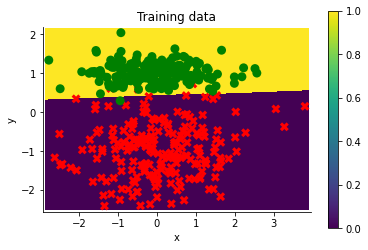

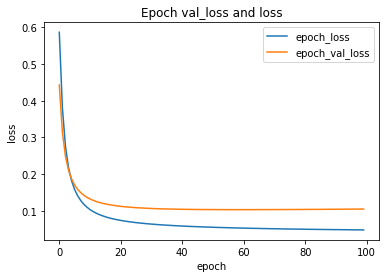

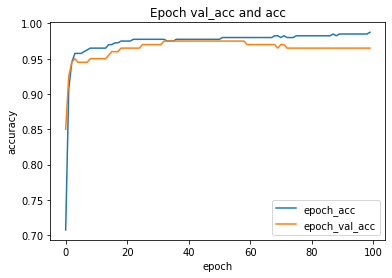


Avg. validation accuracy:0.9649999737739563


(array([[-1.45586427e+00,  1.06759553e+00],
        [-9.15863874e-01,  1.16368824e+00],
        [-5.76529670e-01, -9.03522018e-01],
        [ 1.47028284e+00, -1.02889795e+00],
        [-9.00916800e-01,  1.09612133e+00],
        [ 1.83689989e-01, -2.78607469e-01],
        [-2.69641336e-01, -1.31882248e+00],
        [ 2.97567420e-02, -1.70729600e+00],
        [ 3.59507195e-01,  7.53390980e-01],
        [-1.61810048e-01,  1.17513901e+00],
        [-5.62944237e-01, -1.81517397e+00],
        [ 1.45250817e+00, -1.98062295e+00],
        [-5.68201865e-01,  9.97233331e-01],
        [ 6.65546340e-01, -4.87610678e-01],
        [-5.02895716e-01,  1.03914579e+00],
        [-3.27830527e-01,  1.18556267e+00],
        [ 5.25962696e-01, -2.00777506e+00],
        [ 1.20849816e+00, -5.16103953e-01],
        [-2.77688414e-01, -7.44748537e-01],
        [-4.73362117e-01,  5.83668048e-01],
        [-2.66744646e-01,  1.24707267e+00],
        [-1.67530495e+00,  1.03949695e+00],
        [ 7.74967979e-01, -5.452

In [9]:
run_keras_2d("3", archs(2)[0], 10, split=0.5, display=True, verbose=True, trials=1)

**MNIST Dataset**

In [10]:
######################################################################
# Problem 5
######################################################################

def shifted(X, shift):
    n = X.shape[0]
    m = X.shape[1]
    size = m + shift
    X_sh = np.zeros((n, size, size))
    plt.ion()
    for i in range(n):
        sh1 = np.random.randint(shift)
        sh2 = np.random.randint(shift)
        X_sh[i, sh1:sh1+m, sh2:sh2+m] = X[i, :, :]
        # If you want to see the shifts, uncomment
        #plt.figure(1); plt.imshow(X[i])
        #plt.figure(2); plt.imshow(X_sh[i])
        #plt.show()
        #input('Go?')
    return X_sh
  
def get_MNIST_data(shift=0):
    (X_train, y1), (X_val, y2) = mnist.load_data()
    if shift:
        size = 28+shift
        X_train = shifted(X_train, shift)
        X_val = shifted(X_val, shift)
    return (X_train, y1), (X_val, y2)

# Example Usage:
# train, validation = get_MNIST_data()


In [11]:
def run_keras_fc_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    '''
    train, test = input data
    layers = list of Keras layers, e.g. [Dense(32, input_dim=784), Dense(10)]
    epochs = number of epochs to run the model for each traini
    ng trial
    trials = number of evaluation trials, resetting weights before each trial
    '''
    (X_train, y1), (X_val, y2) = train, test
    # Flatten the images
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m*m))
    X_val = X_val.reshape((X_val.shape[0], m*m))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'kernel_initializer'):
                    initializer_func = getattr(v_arg, 'kernel_initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

def run_keras_cnn_mnist(train, test, layers, epochs, split=0.1, verbose=True, trials=1):
    # Load the dataset
    (X_train, y1), (X_val, y2) = train, test
    # Add a final dimension indicating the number of channels (only 1 here)
    m = X_train.shape[1]
    X_train = X_train.reshape((X_train.shape[0], m, m, 1))
    X_val = X_val.reshape((X_val.shape[0], m, m, 1))
    # Categorize the labels
    num_classes = 10
    y_train = np_utils.to_categorical(y1, num_classes)
    y_val = np_utils.to_categorical(y2, num_classes)
    # Train, use split for validation
    val_acc, test_acc = 0, 0
    for trial in range(trials):
        # Reset the weights
        # See https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in layers:
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg, 'kernel_initializer'):
                    initializer_func = getattr(v_arg, 'kernel_initializer')
                    initializer_func.run(session=session)
        # Run the model
        model, history, vacc, tacc = \
                run_keras(X_train, y_train, X_val, y_val, None, None, layers, epochs, split=split, verbose=verbose)
        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))

In [12]:
layers = [Dense(input_dim=784, units=10, activation='relu'),
             Dense(units=10, activation="softmax")]# Your code
train, validation = get_MNIST_data()
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

1875/1875 [==============================] - 3s 2ms/step - loss: 2.3097 - acc: 0.1855 - val_loss: 2.0256 - val_acc: 0.2049

Loss on validation set:2.0255703926086426 Accuracy on validation set: 0.20489999651908875
1875/1875 [==============================] - 3s 2ms/step - loss: 2.0163 - acc: 0.2093 - val_loss: 1.9921 - val_acc: 0.2135

Loss on validation set:1.9921388626098633 Accuracy on validation set: 0.2134999930858612
1875/1875 [==============================] - 3s 2ms/step - loss: 1.9336 - acc: 0.2492 - val_loss: 1.8648 - val_acc: 0.3031

Loss on validation set:1.8648078441619873 Accuracy on validation set: 0.30309998989105225
1875/1875 [==============================] - 3s 2ms/step - loss: 1.7399 - acc: 0.3246 - val_loss: 1.6598 - val_acc: 0.3324

Loss on validation set:1.659815788269043 Accuracy on validation set: 0.33239999413490295
1875/1875 [==============================] - 3s 2ms/step - loss: 1.6169 - acc: 0.3532 - val_loss: 1.5230 - val_acc: 0.3966

Loss on validation set

In [13]:
layers = [Dense(input_dim=784, units=10, activation='relu', 
                kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None)),
             Dense(units=10, activation="softmax", 
                   kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None))]
train, validation = get_MNIST_data()
run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.4522 - acc: 0.8672 - val_loss: 0.4056 - val_acc: 0.8763

Loss on validation set:0.4056289494037628 Accuracy on validation set: 0.8762999773025513
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3747 - acc: 0.8932 - val_loss: 0.3937 - val_acc: 0.8935

Loss on validation set:0.39369744062423706 Accuracy on validation set: 0.8934999704360962
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3571 - acc: 0.9011 - val_loss: 0.3559 - val_acc: 0.9044

Loss on validation set:0.3558571934700012 Accuracy on validation set: 0.9043999910354614
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3469 - acc: 0.9073 - val_loss: 0.3275 - val_acc: 0.9126

Loss on validation set:0.327526718378067 Accuracy on validation set: 0.9125999808311462
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3328 - acc: 0.9114 - val_loss: 0.3612 - val_acc: 0.9116

Loss on validation set:0

In [14]:
layers = [Dense(input_dim=784, units=10, activation='relu', 
                kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None)),
             Dense(units=10, activation="softmax", 
                   kernel_initializer=VarianceScaling(scale=0.001, mode='fan_in', distribution='normal', seed=None))]
                   
train, validation = get_MNIST_data()
train = train[0] / 255, train[1]
validation = validation[0] / 255, validation[1]

run_keras_fc_mnist(train, validation, layers, 1, split=0.1, verbose=True, trials=5)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.5660 - acc: 0.8399 - val_loss: 0.3229 - val_acc: 0.9060

Loss on validation set:0.3228769600391388 Accuracy on validation set: 0.906000018119812
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3102 - acc: 0.9120 - val_loss: 0.2834 - val_acc: 0.9179

Loss on validation set:0.2833908796310425 Accuracy on validation set: 0.917900025844574
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2847 - acc: 0.9198 - val_loss: 0.2743 - val_acc: 0.9213

Loss on validation set:0.274305522441864 Accuracy on validation set: 0.9212999939918518
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2711 - acc: 0.9229 - val_loss: 0.2666 - val_acc: 0.9209

Loss on validation set:0.26655998826026917 Accuracy on validation set: 0.9208999872207642
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2619 - acc: 0.9255 - val_loss: 0.2562 - val_acc: 0.9275

Loss on validation set:0.2

MNIST Datasets

In [15]:
train, validation = get_MNIST_data()
def rescale(data):
    X, y = data
    X = X/255.
    return (X,y)
train = rescale(train)
validation = rescale(validation)
for unit in (128, 256, 512, 1024):
    print('units: ', unit)
    arch = [Dense(input_dim=28*28, units=unit, activation="relu"),
    Dense(units=10, activation="softmax")]
    run_keras_fc_mnist(train, validation, arch, epochs=1, split=0.1, verbose=False, trials=5)

units:  128

Loss on validation set:0.13888800144195557 Accuracy on validation set: 0.9559999704360962

Loss on validation set:0.10372381657361984 Accuracy on validation set: 0.9682000279426575

Loss on validation set:0.0946153998374939 Accuracy on validation set: 0.9696999788284302

Loss on validation set:0.08260346949100494 Accuracy on validation set: 0.973800003528595

Loss on validation set:0.07998797297477722 Accuracy on validation set: 0.9742000102996826

Avg. validation accuracy:0.9683799982070923
units:  256

Loss on validation set:0.12085343897342682 Accuracy on validation set: 0.9646999835968018

Loss on validation set:0.0888831689953804 Accuracy on validation set: 0.973800003528595

Loss on validation set:0.07163713127374649 Accuracy on validation set: 0.9768999814987183

Loss on validation set:0.06572262197732925 Accuracy on validation set: 0.9783999919891357

Loss on validation set:0.07673323154449463 Accuracy on validation set: 0.9765999913215637

Avg. validation accuracy

In [16]:
arch = [Dense(input_dim=28*28, units=512, activation="relu"),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation="softmax")]
run_keras_fc_mnist(train, validation, arch, epochs=1, split=0.1, verbose=False, trials=5)


Loss on validation set:0.09789329022169113 Accuracy on validation set: 0.9695000052452087

Loss on validation set:0.07217810302972794 Accuracy on validation set: 0.9771000146865845

Loss on validation set:0.08390434831380844 Accuracy on validation set: 0.9757000207901001

Loss on validation set:0.07421457767486572 Accuracy on validation set: 0.9789000153541565

Loss on validation set:0.08654965460300446 Accuracy on validation set: 0.9783999919891357

Avg. validation accuracy:0.9759200096130372


In [17]:

FC_Layer = [Dense(input_dim=48*48, units=512, activation="relu"),
    Dense(units=256, activation='relu'),
    Dense(units=10, activation="softmax")]


# Trying cnn:
CNN_layers = [Conv2D(filters=32, kernel_size=(3,3),input_shape=(48, 48, 1), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
          MaxPooling2D(pool_size=(2, 2)), 
          Flatten(),
          Dense(units=128, activation='relu'),
          Dropout(rate = .5),
          Dense(units=10, activation='softmax')]

layers = [Conv2D(filters=32, kernel_size=(3,3),input_shape=(28, 28, 1), activation="relu"),
          MaxPooling2D(pool_size=(2, 2)),
          Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
          MaxPooling2D(pool_size=(2, 2)), 
          Flatten(),
          Dense(units=128, activation='relu'),
          Dropout(rate = .5),
          Dense(units=10, activation='softmax')]

run_keras_cnn_mnist(train, validation, layers, epochs=1, split=0.1, verbose=False, trials=1)



# Shifted dataset
train_20, validation_20 = get_MNIST_data(shift=20)
train_20 = rescale(train_20)
validation_20 = rescale(validation_20)
print('FC result')
run_keras_fc_mnist(train_20, validation_20, FC_Layer, epochs=1, split=0.1, verbose=False, trials=5)
print('CNN result')
run_keras_cnn_mnist(train_20, validation_20, CNN_layers, epochs=1, split=0.1, verbose=False, trials=1)


Loss on validation set:0.0456119030714035 Accuracy on validation set: 0.9854999780654907

Avg. validation accuracy:0.9854999780654907
FC result

Loss on validation set:0.40554291009902954 Accuracy on validation set: 0.8708000183105469

Loss on validation set:0.35256803035736084 Accuracy on validation set: 0.8871999979019165

Loss on validation set:0.3254600465297699 Accuracy on validation set: 0.9038000106811523

Loss on validation set:0.35762327909469604 Accuracy on validation set: 0.9016000032424927

Loss on validation set:0.36984285712242126 Accuracy on validation set: 0.9067000150680542

Avg. validation accuracy:0.8940200090408326
CNN result

Loss on validation set:0.14420950412750244 Accuracy on validation set: 0.9567999839782715

Avg. validation accuracy:0.9567999839782715
